# **Dependencies**

In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
!pip uninstall transformer
!pip install git+https://github.com/huggingface/transformers
!pip install mamba-ssm[causal-conv1d]==2.2.4 --no-build-isolation
!pip install rouge-score
!pip install grad-cam

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-fgeiy3_8
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-fgeiy3_8
  Resolved https://github.com/huggingface/transformers to commit bb45d3631ec7026db04a77d33a52b31766372160
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 66.7 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.57.0.dev0-py3-none-any.whl size=12594930 sha256=4c138f397c0dc59b1a5c30c7c0d7de8452aaac408e083449b6bc2b20291eefd8
  Stored in directory: /tmp/pip-ephem-wheel-cache-nfli_wnk/wheels/04/a3/f1/b88775f8e1665827525b19ac7590250f1038d947067beba9fb
Successfully built transformers
  Attempting uninstall: huggingface-hub
    Found existing i

# **Data Preprocessing , DataSet and DataLoaders**

In [3]:
import os
import xml.etree.ElementTree as ET
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import GPT2Tokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torchvision import models
import math
from torch.cuda.amp import GradScaler, autocast
from transformers import get_cosine_schedule_with_warmup
from peft import get_peft_model, LoraConfig, TaskType
from tqdm import tqdm
import pandas as pd
import numpy as np
import gc
import re
from transformers import BitsAndBytesConfig
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup

2025-09-05 19:08:25.827220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757099306.086924      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757099306.174372      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


# **Configuration**

In [5]:
MIMIC_DATA_PATH = "/kaggle/input/p10-processed-data"

# Keep these parameters from your original code
TOKENIZER_NAME   = "gpt2"
BATCH_SIZE       = 4 # Or whatever your GPU can handle
MAX_SEQ_LENGTH   = 256
IMAGE_SIZE       = 224
TRAIN_RATIO      = 0.80
VALID_RATIO      = 0.10
TEST_RATIO       = 0.10
RANDOM_STATE     = 42

In [6]:
# 2) Cleaning, patient-id extraction, manifest builder (multi-view + patient_id)

import re

_period_collapse = re.compile(r"\.{2,}")
_punct = re.compile(r'[,\?;*!%^&_+():\[\]{}"\\/]+')

def clean_text(text):
    if not text: return ""
    text = text.replace('xxxx', '').replace('\n', ' ').replace('\r', ' ')
    text = _period_collapse.sub('.', text)
    text = text.strip().lower()
    sents = [s.strip() for s in text.split('.') if s.strip()]
    def sent_clean(s):
        s = _punct.sub('', s)
        s = re.sub(r"\s+", " ", s)
        return s
    tokens = [sent_clean(s) for s in sents if sent_clean(s)]
    report = ' . '.join(tokens) + ' .'
    return report


In [7]:
class MIMIC_CXR_Dataset(Dataset):
    def __init__(self, manifest, tokenizer, image_transform=None, max_seq_length=512):
        self.manifest = manifest
        self.tokenizer = tokenizer
        self.image_transform = image_transform
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        item = self.manifest[idx]
        findings_text = clean_text(item['report_findings'])
        impression_text = clean_text(item['report_impression'])
        full_report = f"<SECTION_FINDINGS> {findings_text} <SECTION_IMPRESSION> {impression_text} <|endoftext|>"
        raw_labels = item['labels']
        chexpert_labels = torch.tensor(
        [1.0 if l == 1.0 else 0.0 for l in raw_labels], dtype=torch.float)
        chexpert_mask = torch.tensor(
        [1.0 if l is not None and l != -1.0 else 0.0 for l in raw_labels], dtype=torch.float)
        image_tensors_pre = item['images']
        image_tensors_post = []

        for img_tensor in image_tensors_pre:
            # === FIX FOR BLACK IMAGE ===
            # 1. Convert tensor [0,1] back to a PIL Image [0,255]
            pil_image = transforms.ToPILImage()(img_tensor)
            # 2. Convert PIL Image to NumPy array, which is the standard [0,255] uint8 format
            image_np = np.array(pil_image)
            # 3. Now, pass this standard format to Albumentations
            # ===========================

            if self.image_transform:
                transformed = self.image_transform(image=image_np)
                image_tensor_aug = transformed['image']
            else:
                image_tensor_aug = img_tensor

            image_tensors_post.append(image_tensor_aug)

        tokenized = self.tokenizer(
            full_report, padding="max_length", truncation=True,
            max_length=self.max_seq_length, return_tensors="pt",
        )
        input_ids = tokenized["input_ids"].squeeze(0)
        attention_mask = tokenized["attention_mask"].squeeze(0)
        labels = input_ids.clone()
        labels[attention_mask == 0] = -100

        return {
            "images": image_tensors_post,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "chexpert_labels": chexpert_labels, # The clean 0/1 target
            "chexpert_mask": chexpert_mask,     # The 0/1 mask
            "labels": labels,
            "patient_id": item.get("subject_id", None)
        }

In [8]:
from transformers import GPT2TokenizerFast

tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

# First add additional specials, then add pad token as [PAD]
tokenizer.add_special_tokens({"additional_special_tokens": ["<SECTION_FINDINGS>", "<SECTION_IMPRESSION>"]})
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"
# Sanity check (optional)
print("pad_token:", tokenizer.pad_token, "pad_token_id:", tokenizer.pad_token_id)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

pad_token: <|endoftext|> pad_token_id: 50256


In [9]:
def make_collate_fn(pad_token_id: int):
    def _collate(batch):
        if len(batch) == 0:
            raise ValueError("Empty batch received by collate_fn.")

        image_lists = [it['images'] for it in batch]
        chexpert_labels = torch.stack([it['chexpert_labels'] for it in batch])
        chexpert_mask = torch.stack([it['chexpert_mask'] for it in batch])
        input_ids_list = [it['input_ids'] for it in batch]
        labels_list = [it['labels'] for it in batch]

        max_views = max(len(images) for images in image_lists)

        batch_images, mask = [], []
        for images in image_lists:
            if len(images) == 0:
                raise ValueError("Found a sample with zero images/views. Check your manifest.")
            last_image = images[-1]
            padded = images + [last_image] * (max_views - len(images))
            batch_images.append(torch.stack(padded))  # (V,3,H,W)
            mask.append([1] * len(images) + [0] * (max_views - len(images)))

        batch_images = torch.stack(batch_images)                # (B,V,3,H,W)
        view_mask   = torch.tensor(mask, dtype=torch.bool)      # (B,V)
        input_ids     = torch.stack([it['input_ids'] for it in batch])
        attention_mask= torch.stack([it['attention_mask'] for it in batch])
        labels        = torch.stack([it['labels'] for it in batch]).clone()  # (B,T)

        labels[attention_mask == 0] = -100

        return {
            'images': batch_images,
            'view_mask': view_mask,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels,
            'chexpert_labels': chexpert_labels,
            'chexpert_mask': chexpert_mask,
        }
    return _collate

# Remember to re-create the collate function instance
collate_fn = make_collate_fn(tokenizer.pad_token_id)

# **Loaded Data Visualization**

In [10]:

import os, random, numpy as np, torch

def set_global_seed(seed: int = 9223, deterministic: bool = True):
    # Python & NumPy
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # cuDNN / deterministic behavior
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    else:
        # Slightly faster but less reproducible
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True

    # Torch compile caches, dataloader reproducibility knobs (optional)
    os.environ.setdefault("CUBLAS_WORKSPACE_CONFIG", ":4096:8")  # for determinism on some ops
    # If using torch>=2.0, some ops may still be nondeterministic; see PyTorch docs.

# Call once, before any randomness-dependent code (tokenizer/dataloaders/models)
GLOBAL_SEED = 9223
set_global_seed(GLOBAL_SEED, deterministic=True)


In [11]:
def _worker_init_fn(worker_id):
    # Ensures each worker has a distinct, reproducible seed
    worker_seed = (GLOBAL_SEED + worker_id) % (2**32)
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(GLOBAL_SEED)


In [12]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define the image size your MambaVision model expects
IMAGE_SIZE = 224 # Or 384, etc.

# This is a balanced and safe pipeline for training
train_transform = A.Compose([
    # 1. Safely resize the image. This is better than a random crop which might
    #    cut out important pathologies.
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1.0),

    # 2. Simulate variations in patient positioning. These are the most
    #    important and safest geometric augmentations for X-rays.
    A.ShiftScaleRotate(
        shift_limit=0.05,      # Max 5% shift in x/y
        scale_limit=0.1,       # Max 10% zoom in/out
        rotate_limit=15,       # Max 15 degrees rotation
        p=0.9                    # Apply this transform 90% of the time
    ),

    # 3. Flip the image horizontally. This is a standard and safe augmentation.
    A.HorizontalFlip(p=0.5),

    # 4. Simulate variations in X-ray exposure and contrast.
    A.RandomBrightnessContrast(
        brightness_limit=0.2,  # Max 20% change in brightness
        contrast_limit=0.2,    # Max 20% change in contrast
        p=0.8                    # Apply this 80% of the time
    ),

    # 5. (Optional) Add a small amount of Gaussian noise.
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.25),

    # 6. Normalize and convert to a PyTorch tensor.
    #    IMPORTANT: X-rays are 1-channel, but pretrained models expect 3 channels.
    #    Your data loader must duplicate the single channel 3 times *before* this step.
    A.Normalize(
        mean=[0.485, 0.456, 0.406], # Standard ImageNet mean
        std=[0.229, 0.224, 0.225]   # Standard ImageNet std
    ),
    ToTensorV2(),
])

# The validation transform should be minimal: just resize and normalize.
val_transform = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1.0),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    ToTensorV2(),
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_19/4089228310.py:33: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.25),


Loading pre-processed MIMIC-CXR dataset chunks...
 → Loading /kaggle/input/p10-processed-data/mimic_dataset_224_part_1.pt
 → Loading /kaggle/input/p10-processed-data/mimic_dataset_224_part_2.pt
 → Loading /kaggle/input/p10-processed-data/mimic_dataset_224_part_3.pt
 → Loading /kaggle/input/p10-processed-data/mimic_dataset_224_part_4.pt
 → Loading /kaggle/input/p10-processed-data/mimic_dataset_224_part_5.pt
 → Loading /kaggle/input/p10-processed-data/mimic_dataset_224_part_6.pt
 → Loading /kaggle/input/p10-processed-data/mimic_dataset_224_part_7.pt
✅ Total studies combined: 14000

Data successfully split (patient-level, no leakage):
Unique patients total: 4108
Train patients: 3286, Val patients: 411, Test patients: 411
Training studies:   11205
Validation studies: 1485
Test studies:       1310

PyTorch DataLoaders for MIMIC-CXR are ready!

--- Verifying a sample batch from the train_loader ---
Batch keys: dict_keys(['images', 'view_mask', 'input_ids', 'attention_mask', 'labels', 'chexpe

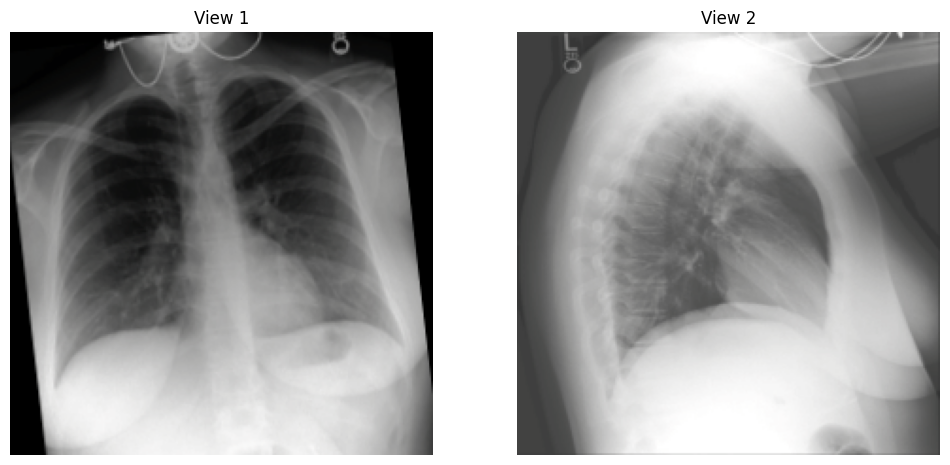


--- Sample Report (Decoded) ---
 the lungs are clear without focal consolidation . no pleural effusion or pneumothorax is seen . the cardiac and mediastinal silhouettes are unremarkable .  no acute cardiopulmonary process . 
Chexpert lables:-  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
Chexpert Mask:-  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
--------------------------------------------------


In [13]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from glob import glob

# print("Loading pre-processed MIMIC-CXR dataset...")
# full_manifest = torch.load(MIMIC_DATA_PATH, map_location="cpu")
# print(f"Total studies loaded: {len(full_manifest)}")

print("Loading pre-processed MIMIC-CXR dataset chunks...")

# Find all chunk files
chunk_files = sorted(glob(os.path.join(MIMIC_DATA_PATH, "mimic_dataset_224_part_*.pt")))

# Load and merge all chunks
full_manifest = []
for chunk_path in chunk_files:
    print(f" → Loading {chunk_path}")
    data = torch.load(chunk_path, map_location="cpu")
    full_manifest.extend(data)

print(f"✅ Total studies combined: {len(full_manifest)}")

# Patient-level split to prevent data leakage
all_patients = sorted(list(set(m['subject_id'] for m in full_manifest)))
random.Random(RANDOM_STATE).shuffle(all_patients)

n_patients = len(all_patients)
n_train = int(round(TRAIN_RATIO * n_patients))
n_val   = int(round(VALID_RATIO * n_patients))

train_patients = set(all_patients[:n_train])
val_patients   = set(all_patients[n_train:n_train+n_val])
test_patients  = set(all_patients[n_train+n_val:])

def filter_by_patients(manifest, keep_patients):
    # Note the change from 'patient_id' to 'subject_id' here
    return [m for m in manifest if m['subject_id'] in keep_patients]

train_manifest = filter_by_patients(full_manifest, train_patients)
val_manifest   = filter_by_patients(full_manifest, val_patients)
test_manifest  = filter_by_patients(full_manifest, test_patients)

print("\nData successfully split (patient-level, no leakage):")
print(f"Unique patients total: {n_patients}")
print(f"Train patients: {len(train_patients)}, Val patients: {len(val_patients)}, Test patients: {len(test_patients)}")
print(f"Training studies:   {len(train_manifest)}")
print(f"Validation studies: {len(val_manifest)}")
print(f"Test studies:       {len(test_manifest)}")

# --- 4) Datasets and DataLoaders ---
# Albumentations pipelines remain the same from your original code.
# The train_transform and val_transform objects should be defined before this.

train_dataset = MIMIC_CXR_Dataset(train_manifest, tokenizer, train_transform, max_seq_length=MAX_SEQ_LENGTH)
val_dataset   = MIMIC_CXR_Dataset(val_manifest,   tokenizer, val_transform,   max_seq_length=MAX_SEQ_LENGTH)
test_dataset  = MIMIC_CXR_Dataset(test_manifest,  tokenizer, val_transform,   max_seq_length=MAX_SEQ_LENGTH)

# The collate_fn and worker_init_fn are unchanged.
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=collate_fn,
    worker_init_fn=_worker_init_fn, generator=g, persistent_workers=True, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn,
    worker_init_fn=_worker_init_fn, generator=g, persistent_workers=True, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn,
    worker_init_fn=_worker_init_fn, generator=g, persistent_workers=True, pin_memory=True
)

print("\nPyTorch DataLoaders for MIMIC-CXR are ready!")

# --- 5) CORRECTED Sanity Check and Visualization ---
print("\n--- Verifying a sample batch from the train_loader ---")
sample_batch = next(iter(train_loader))
print(f"Batch keys: {sample_batch.keys()}")
print(f"Image tensor shape:      {sample_batch['images'].shape}")
print(f"View mask shape:         {sample_batch['view_mask'].shape}")
print(f"Input IDs tensor shape:  {sample_batch['input_ids'].shape}")
print(f"Chexpert Lables: {sample_batch['chexpert_labels'].shape}")
print(f"Chexpert mask: {sample_batch['chexpert_mask'].shape}")
# Visualize all views for a random study
idx_to_show = random.randint(0, sample_batch['images'].size(0) - 1)
images_to_show = sample_batch['images'][idx_to_show]
view_mask = sample_batch['view_mask'][idx_to_show]
num_views = view_mask.sum().item()

# De-normalize for visualization
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

plt.figure(figsize=(6 * num_views, 6))
for i in range(num_views):
    img_tensor = images_to_show[i]
    img_display = (img_tensor * std) + mean # De-normalize
    img_display = transforms.ToPILImage()(img_display.clamp(0, 1)) # Clamp to ensure valid range
    plt.subplot(1, num_views, i+1)
    plt.imshow(img_display)
    plt.title(f"View {i+1}")
    plt.axis('off')
plt.show()

# Decode report for that study
input_ids_display = sample_batch['input_ids'][idx_to_show]

# === FIX FOR [EOS] TOKENS ===
# Use skip_special_tokens=True to get a clean, human-readable output
report_display = tokenizer.decode(input_ids_display, skip_special_tokens=True)
# ============================

print("\n--- Sample Report (Decoded) ---")
print(report_display)
print(f"Chexpert lables:-  {sample_batch['chexpert_labels'][idx_to_show]}")
print(f"Chexpert Mask:-  {sample_batch['chexpert_mask'][idx_to_show]}")
print("-" * 50)

# **MambaVision**

In [14]:
import torch
import torch.nn as nn
from transformers import AutoModel

class MambaVisionEncoder(nn.Module):
    """
    A unified MambaVision class that can be used for multi-label classification
    (for pre-training) or as a powerful feature encoder for report generation.
    """
    def __init__(self, model_name="nvidia/MambaVision-S-1K", num_labels=14, device="cuda", dropout_rate=0.3,
                 for_report_generation=False, trained_classifier_path=None):
        super().__init__()
        self.device = device
        self.for_report_generation = for_report_generation

        # 1. Load the base MambaVision model from Hugging Face
        self.encoder = AutoModel.from_pretrained(
            model_name,
            trust_remote_code=True
        ).to(device)

        # 2. Infer hidden dimension from the model itself
        self.encoder.eval()
        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224, device=device)
            pooled_feats, _ = self.encoder(dummy)
            hidden_dim = pooled_feats.shape[-1]

        print(f"Inferred hidden dimension: {hidden_dim}")

        # 3. Define the classification head (only used if for_report_generation is False)
        self.label_head = nn.Sequential(
            nn.Linear(hidden_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_labels)
        ).to(device)

        # 4. Load pre-trained weights if a path is provided (with robust loading)
        if trained_classifier_path:
            print(f"Loading pre-trained classifier weights from: {trained_classifier_path}")
            checkpoint = torch.load(trained_classifier_path, map_location=device)
            # Handle both raw state_dict and checkpoint dictionaries
            if 'model_state_dict' in checkpoint:
                state_dict = checkpoint['model_state_dict']
            else:
                state_dict = checkpoint
            
            # Handle weights from a compiled model (_orig_mod prefix)
            unwrapped_state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}
            
            # Use strict=False to gracefully handle loading only encoder weights
            # if the saved model doesn't have the classification head.
            self.load_state_dict(unwrapped_state_dict, strict=False)
            print("Successfully loaded pre-trained weights.")

        # 5. Set initial state
        self.encoder.eval()
        self.frozen = False
        self.freeze() # Start with the encoder frozen by default

    def forward(self, image_tensor):
        """
        Forward pass behavior depends on the 'for_report_generation' flag.
        """
        pooled_feats, features = self.encoder(image_tensor)
        
        if self.for_report_generation:
            # Mode 1: Report Generation - Return patch features
            last_stage_features = features[-1]
            patch_tokens = last_stage_features.flatten(2).permute(0, 2, 1)
            return patch_tokens, features
        else:
            # Mode 2: Classification - Return logits
            logits = self.label_head(pooled_feats)
            return logits, {'pooled': pooled_feats, 'patch': features}

    def freeze(self):
        self.frozen = True
        self.encoder.eval()
        print("Freezing encoder layers.")
        for param in self.encoder.parameters():
            param.requires_grad = False

    def unfreeze(self):
        self.frozen = False
        self.encoder.train()
        print("Unfreezing all encoder layers.")
        for param in self.encoder.parameters():
            param.requires_grad = True

    def unfreeze_encoder_top_layers(self, num_levels_to_unfreeze=1):
        if num_levels_to_unfreeze < 0 or num_levels_to_unfreeze > len(self.encoder.model.levels):
            raise ValueError("num_levels_to_unfreeze must be between 0 and 4.")

        self.freeze()
        if num_levels_to_unfreeze > 0:
            print(f"Unfreezing the last {num_levels_to_unfreeze} encoder level(s)...")
            self.frozen = False
            self.encoder.train()
            for i in range(num_levels_to_unfreeze):
                level_to_unfreeze = self.encoder.model.levels[-(i + 1)]
                for param in level_to_unfreeze.parameters():
                    param.requires_grad = True
        else:
            print("Encoder remains frozen.")

In [15]:
# import torch
# import torch.nn.functional as F
# import matplotlib.pyplot as plt
# import numpy as np
# from torchvision import transforms
# import random

# # --- Global storage ---
# final_feature_map = None
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# # --- Hook to capture patch features ---
# def forward_hook(module, input, output):
#     global final_feature_map
#     final_feature_map = output.detach()  # [1, N, C]

# # --- Load model ---
# print("Instantiating model architecture...")
# inference_model = MambaVisionEncoder(
#     model_name="nvidia/MambaVision-S-1K",
#     for_report_generation=False,
#     trained_classifier_path="/kaggle/input/checkpoint-83-06/best_mamba_multilabel_v2 (1).pth",
#     device=DEVICE
# ).to(DEVICE)
# inference_model.eval()

# # --- Register hook on last mixer block ---
# target_layer = inference_model.encoder.model.levels[3].blocks[-1].mixer
# fwd_hook = target_layer.register_forward_hook(forward_hook)
# print(f"Hook registered on: {target_layer.__class__.__name__}")

# # --- Mean/Std for denorm ---
# mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(DEVICE)
# std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(DEVICE)

# # --- Visualization loop ---
# num_samples_to_show = 3
# print(f"\n--- Visualizing {num_samples_to_show} samples ---")

# sample_batch = next(iter(test_loader))
# images_batch = sample_batch["images"]  # (B, V, 3, H, W)
# view_mask = sample_batch.get("view_mask", None)

# selected_indices = random.sample(range(images_batch.size(0)), num_samples_to_show)

# for idx in selected_indices:
#     views = []
#     heatmaps = []

#     for v in range(images_batch.size(1)):
#         if view_mask is not None and view_mask[idx, v] == 0:
#             continue

#         img_tensor = images_batch[idx, v].unsqueeze(0).to(DEVICE)  # [1,3,H,W]

#         # --- Forward pass only ---
#         _ = inference_model(img_tensor)  # triggers hook

#         # --- Process patch features to 2D heatmap ---
#         fmap = final_feature_map[0]  # [N, C]
#         N, C = fmap.shape
#         h = w = int(np.sqrt(N))
#         fmap_2d = fmap.reshape(h, w, C)   # [H, W, C]

#         # Convert to heatmap: mean across channels
#         heatmap = fmap_2d.mean(axis=2).cpu().numpy()
#         heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)  # normalize
#         heatmap = F.interpolate(torch.tensor(heatmap).unsqueeze(0).unsqueeze(0),
#                                 size=(224, 224), mode='bilinear', align_corners=False).squeeze().numpy()

#         # Denormalize image for display
#         disp_img = (images_batch[idx, v].cpu() * std.cpu() + mean.cpu()).clamp(0, 1)
#         pil_img = transforms.ToPILImage()(disp_img)

#         views.append(pil_img)
#         heatmaps.append(heatmap)

#     # --- Plot ---
#     num_views = len(views)
#     plt.figure(figsize=(5*num_views, 10))
#     for i, (orig, hmap) in enumerate(zip(views, heatmaps)):
#         plt.subplot(1, num_views, i+1)
#         plt.imshow(orig)
#         plt.imshow(hmap, cmap='jet', alpha=0.5)  # overlay heatmap
#         plt.title(f"Sample {idx} - View {i+1}")
#         plt.axis('off')
#     plt.show()

# # --- Cleanup ---
# fwd_hook.remove()
# print("\nVisualization complete. Hook removed successfully.")

# **EfficientMultiViewTransformerFusion**

In [16]:
class EfficientMultiViewTransformerFusion(nn.Module):
    def __init__(self, vision_dim, num_layers=1, num_heads=4, dropout=0.1, max_views=10):
        super().__init__()
        self.vision_dim = vision_dim
        self.max_views = max_views

        # Learnable view-level positional embeddings (broadcasted over patches of each view)
        self.view_pos_embed = nn.Parameter(torch.zeros(1, max_views, vision_dim))
        nn.init.trunc_normal_(self.view_pos_embed, std=0.02)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=vision_dim, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Single learned query for attention pooling
        self.pool_query = nn.Parameter(torch.randn(1, 1, vision_dim))
        self.pool_attention = nn.MultiheadAttention(
            embed_dim=vision_dim, num_heads=num_heads, dropout=dropout, batch_first=True
        )

    def forward(self, feats, view_mask=None, num_patches_per_view=None):
        """
        feats: 
          - patch-level: (B, V * P, D) where P = num_patches_per_view (preferred for cross-attention)
          - view-level:  (B, V, D)      if passing pooled tokens per view
        view_mask: (B, V) with 1 for valid views, 0 for padded views
        num_patches_per_view: optional int; if None, inferred when possible
        """
        assert feats.dim() == 3, f"feats must be 3D [B, S, D], got {feats.shape}"

        B, S, D = feats.shape
        device = feats.device
        assert D == self.vision_dim, f"D mismatch: feats has {D}, fusion expects {self.vision_dim}"

        # Infer V and P
        if view_mask is not None:
            V = view_mask.size(1)
            if num_patches_per_view is None:
                assert S % V == 0, "Cannot infer patches per view; pass num_patches_per_view explicitly"
                P = S // V
            else:
                P = num_patches_per_view
                assert V * P == S or P == 1 and S == V, "Inconsistent S, V, P; check inputs"
        else:
            # No view_mask: assume either view-level (S=V, P=1) or require P
            if num_patches_per_view is None or num_patches_per_view == 1:
                V, P = S, 1
            else:
                assert S % num_patches_per_view == 0, "S must be divisible by P when inferring V"
                V, P = S // num_patches_per_view, num_patches_per_view

        # View positional embedding broadcast to patches
        assert V <= self.max_views, f"V={V} exceeds max_views={self.max_views}"
        view_pos = self.view_pos_embed[:, :V, :]  # [1, V, D]
        if P > 1:
            view_pos = view_pos.unsqueeze(2).expand(-1, -1, P, -1).reshape(1, V * P, D)  # [1, V*P, D]
        feats = feats + view_pos.to(device)

        # Build key_padding_mask over the token sequence (True = pad/ignore)
        key_padding_mask = None
        if view_mask is not None:
            if P == 1 and S == V:
                key_padding_mask = (view_mask == 0)
            else:
                vm = (view_mask == 0).unsqueeze(2)                   # [B, V, 1]
                vm = vm.expand(-1, -1, P).reshape(B, V * P)          # [B, V*P]
                key_padding_mask = vm
        # Transformer encode
        encoded = self.transformer(feats, src_key_padding_mask=key_padding_mask)  # [B, S, D]

        # Attention pooling with a learned query
        query = self.pool_query.expand(B, -1, -1).to(device)  # [B, 1, D]
        pooled, _ = self.pool_attention(
            query=query, key=encoded, value=encoded, key_padding_mask=key_padding_mask
        )  # [B, 1, D]
        return pooled.squeeze(1), encoded  # [B, D], [B, S, D]


# **Main Block**

In [17]:
import torch
import torch.nn as nn
from transformers import GPT2Config, GPT2LMHeadModel

class VisionLanguageWrapper(nn.Module):
    # UPDATED: Removed proj_layer
    def __init__(self, vision_encoder, custom_gpt2, fusion_module, device='cuda', use_all_views=True):
        super().__init__()
        self.vision_encoder = vision_encoder
        self.gpt2 = custom_gpt2
        self.fusion_module = fusion_module
        self.device = torch.device(device)
        self.use_all_views = use_all_views

    def forward(self, images, input_ids, attention_mask=None, labels=None, view_mask=None, output_attentions=False):
        B, V, C, H, W = images.shape
        images_flat = images.view(B * V, C, H, W)

        # 1. Vision Encoder returns patch features (B * V, Num_Patches, Vision_Dim)
        patch_feats_flat, _ = self.vision_encoder(images_flat)
        _, Num_Patches, Vision_Dim = patch_feats_flat.shape

        # 2. Reshape and flatten for fusion -> (B, V * Num_Patches, Vision_Dim)
        patch_feats_seq = patch_feats_flat.reshape(B, V * Num_Patches, Vision_Dim)

        # 3. Multi-view Fusion
        fused_feats, encoded_views = self.fusion_module(
            patch_feats_seq,
            view_mask=view_mask,
            num_patches_per_view=Num_Patches
        )

        # 4. Select features for the decoder (NO PROJECTION NEEDED)
        if self.use_all_views:
            # Use the entire sequence of patch features from all views
            visual_emb = encoded_views  # Shape: (B, V * Num_Patches, 768)
        else:
            # Use only the single pooled summary feature
            visual_emb = fused_feats.unsqueeze(1) # Shape: (B, 1, 768)

        # 5. GPT-2 Decoder
        outputs = self.gpt2(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=visual_emb,
            labels=labels,
            return_dict=True,
            output_attentions=output_attentions,
        )
        return outputs
        
    # --- Freezing helpers (UPDATED: removed projection) ---
    def freeze_vision_encoder(self):
        if hasattr(self.vision_encoder, "freeze"): self.vision_encoder.freeze()
        else:
            for p in self.vision_encoder.parameters(): p.requires_grad = False

    def unfreeze_vision_encoder(self):
        if hasattr(self.vision_encoder, "unfreeze"): self.vision_encoder.unfreeze()
        else:
            for p in self.vision_encoder.parameters(): p.requires_grad = True

    def freeze_text_decoder(self):
        for p in self.gpt2.parameters(): p.requires_grad = False

    def unfreeze_text_decoder(self):
        for p in self.gpt2.parameters(): p.requires_grad = True
        
    def print_trainable_parameters(self):
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f'Trainable params: {trainable:,} / {total:,}')


    def adapter_parameters(self):
        """
        Returns parameters for the 'adapter' components: fusion module, cross-attention,
        LM head, and token/positional embeddings. This is crucial for Phase 1.
        """
        adapter_params = list(self.fusion_module.parameters())
        
        # Explicitly add embeddings and the LM head
        for name, p in self.gpt2.named_parameters():
            if 'crossattention' in name.lower() or 'lm_head' in name.lower() or 'wte' in name.lower() or 'wpe' in name.lower():
                if p.requires_grad:
                    adapter_params.append(p)
        
        # Ensure no duplicates
        return list(set(adapter_params))

    def gpt2_body_parameters(self):
        """
        Returns the main GPT-2 transformer block parameters, EXCLUDING adapters.
        This is necessary to avoid parameter overlap in the optimizer.
        """
        body_params = []
        adapter_param_ids = {id(p) for p in self.adapter_parameters()}
        
        for name, p in self.gpt2.named_parameters():
            if id(p) not in adapter_param_ids and p.requires_grad:
                body_params.append(p)
                
        return body_params

    def vision_encoder_parameters(self):
        """Returns all parameters of the vision encoder."""
        return [p for p in self.vision_encoder.parameters() if p.requires_grad]

    def freeze_decoder_body(self):
        """Freezes all parts of GPT-2 except cross-attention and the LM head."""
        for name, p in self.gpt2.named_parameters():
            if 'crossattention' not in name.lower() and 'lm_head' not in name.lower():
                p.requires_grad = False

    # --- from_pretrained factory method (UPDATED) ---
    @classmethod
    def from_pretrained(cls, vision_encoder, fusion_module, tokenizer, device='cuda'):
        config = GPT2Config.from_pretrained("gpt2")
        config.add_cross_attention = True
        config.is_decoder = True
        config.output_attentions = True

        hf_gpt2 = GPT2LMHeadModel(config)
        pretrained = GPT2LMHeadModel.from_pretrained("gpt2")
        missing, unexpected = hf_gpt2.load_state_dict(pretrained.state_dict(), strict=False)
        print("Missing keys (cross-attn etc.):", len(missing), "Unexpected:", len(unexpected))
        hf_gpt2.resize_token_embeddings(len(tokenizer))

        return cls(
            vision_encoder=vision_encoder,
            custom_gpt2=hf_gpt2,
            fusion_module=fusion_module,
            device=device
        ).to(device)

In [18]:
from types import SimpleNamespace
from pathlib import Path

# Model-related configuration (for VisionLanguageWrapper and custom GPT-2)
model_config = SimpleNamespace(
    vocab_size = 50_257,         # GPT-2 vocabulary size
    embed_dim = 768,             # Embedding dimension for GPT-2
    num_heads = 12,              # Number of attention heads
    seq_len = 1024,              # Maximum sequence length (tokens)
    depth = 12,                  # Number of transformer layers (blocks)
    attention_dropout = 0.1,     # Dropout for attention layers
    residual_dropout = 0.1,      # Dropout on residual connections
    mlp_ratio = 4,               # FFN hidden size = embed_dim * mlp_ratio
    mlp_dropout = 0.1,           # Dropout for MLP/FFN sublayer
    emb_dropout = 0.1,           # Dropout on embeddings
    vision_dim = 768,            # Output dim of MambaVision encoder's pooled features
    gpt2_emb_dim = 768,          # Input/output dim of GPT-2 embeddings/projection
)



In [19]:
from types import SimpleNamespace
from pathlib import Path

# --- REVISED Training Configuration for STABLE Full Fine-Tuning ---
train_config = SimpleNamespace(
    # --- Phase Control (Phase 1 is now longer) ---
    epochs = 15,
    unfreeze_decoder_epoch = 5,      # EXTENDED: Give Phase 1 a full 8 epochs to stabilize.
    unfreeze_vision_epoch = 10,      # EXTENDED: Start polishing vision much later.
    num_vision_layers_to_unfreeze=2,

    # --- Differential Learning Rates (Phase 1 LR is much lower) ---
    lr_phase1_adapters = 1e-5,       # CRITICAL CHANGE: Drastically reduced LR for the new "glue" layers.
    lr_phase2_gpt_body = 8e-6,       # Keep these small for when we reach them.
    lr_phase2_adapters = 8e-6,       # Match the gpt_body LR for stability.
    lr_phase3_vision = 1e-6,
    lr_phase3_gpt_body = 5e-6,
    lr_phase3_adapters = 5e-6,

    # --- General Optimizer & Scheduler Settings ---
    device = 'cuda',
    model_path = Path('vl_captioner_full_finetune_stable_v2'), # New path
    batch_size = 8,
    optim = 'AdamW',
    weight_decay = 0.05,
    amsgrad = False,
    lr_scheduler = 'CosineAnnealingLR',
    T_max = 15,                      # Match total epochs
    eta_min = 1e-7,

    # --- Other Training Settings ---
    grad_accum_steps = 4,
    use_amp = True,
    wandb_project = "vl_captioner",
    wandb_run_name = "full_finetune_stable_v2",
    use_wandb = False,
)

In [20]:
import torch
import torch.nn as nn

def reinitialize_cross_attention_weights(model):
    """
    Properly initializes the weights of NEW cross-attention layers using a standard
    random initialization (Kaiming Normal), which is a best practice.
    This replaces the flawed strategy of copying self-attention weights.
    """
    print("Re-initializing cross-attention layers with Kaiming Normal...")
    
    for layer in model.gpt2.transformer.h:
        if hasattr(layer, 'crossattention'):
            # Initialize the attention projections (K, V, and output)
            nn.init.kaiming_normal_(layer.crossattention.c_attn.weight, nonlinearity='relu')
            nn.init.kaiming_normal_(layer.crossattention.c_proj.weight, nonlinearity='relu')
            
            # Initialize biases to zero
            if layer.crossattention.c_attn.bias is not None:
                nn.init.zeros_(layer.crossattention.c_attn.bias)
            if layer.crossattention.c_proj.bias is not None:
                nn.init.zeros_(layer.crossattention.c_proj.bias)
                
            print("  - Re-initialized one cross-attention block.")

    print("Cross-attention re-initialization complete.")

In [21]:
from peft import get_peft_model, LoraConfig, TaskType
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PRETRAINED_CLASSIFIER_PATH = "/kaggle/input/checkpoint-83-06/best_mamba_multilabel_v2 (1).pth" 

vision_encoder = MambaVisionEncoder(
    model_name="nvidia/MambaVision-S-1K",
    for_report_generation=True,
    trained_classifier_path="/kaggle/input/checkpoint-83-06/best_mamba_multilabel_v2 (1).pth",
    device=DEVICE
).to(DEVICE)

# Fusion module
fusion_module = EfficientMultiViewTransformerFusion(
    vision_dim=model_config.vision_dim,
    num_layers=4,
    num_heads=8,
    dropout=0.4
).to(train_config.device)

# Wrapper instantiation (corrected)
vl_model = VisionLanguageWrapper.from_pretrained(
    vision_encoder=vision_encoder,
    fusion_module=fusion_module,
    tokenizer=tokenizer,
    device=train_config.device
)
reinitialize_cross_attention_weights(vl_model)

print("\\n--- Trainable Parameters (Before LoRA) ---")
vl_model.print_trainable_parameters()

# lora_config_advanced = LoraConfig(
#     r=8,                   # Increased capacity
#     lora_alpha=16,          # Maintain scaling factor
#     target_modules=[
#         "c_attn",
#         "c_proj",
#         "c_fc"
#     ],                      # Adapt attention AND feed-forward layers
#     lora_dropout=0.1,       # Slightly increased dropout
#     bias="none",
#     task_type=TaskType.CAUSAL_LM
# )

# # Then apply it to your model
# vl_model.gpt2 = get_peft_model(vl_model.gpt2, lora_config_advanced)


# print("\\n--- Trainable Parameters (After LoRA) ---")
# vl_model.print_trainable_parameters()


config.json: 0.00B [00:00, ?B/s]

configuration_mambavision.py:   0%|          | 0.00/625 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-S-1K:
- configuration_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_mambavision.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-S-1K:
- modeling_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


model.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

Inferred hidden dimension: 768
Loading pre-trained classifier weights from: /kaggle/input/checkpoint-83-06/best_mamba_multilabel_v2 (1).pth


The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Successfully loaded pre-trained weights.
Freezing encoder layers.


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Missing keys (cross-attn etc.): 96 Unexpected: 0


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Re-initializing cross-attention layers with Kaiming Normal...
  - Re-initialized one cross-attention block.
  - Re-initialized one cross-attention block.
  - Re-initialized one cross-attention block.
  - Re-initialized one cross-attention block.
  - Re-initialized one cross-attention block.
  - Re-initialized one cross-attention block.
  - Re-initialized one cross-attention block.
  - Re-initialized one cross-attention block.
  - Re-initialized one cross-attention block.
  - Re-initialized one cross-attention block.
  - Re-initialized one cross-attention block.
  - Re-initialized one cross-attention block.
Cross-attention re-initialization complete.
\n--- Trainable Parameters (Before LoRA) ---
Trainable params: 177,636,878 / 227,777,462


In [22]:
import torch

def build_optimizer(args, model, verbose=True):
    ve_params = list(model.visual_extractor_parameters())
    ed_params = list(model.decoder_parameters())

    OptimClass = getattr(torch.optim, args.optim)  # e.g., 'AdamW' or 'Adam'
    optim_kwargs = {
        'params': [
            {'params': ve_params, 'lr': args.lr_ve, 'name': 'vision_encoder'},
            {'params': ed_params, 'lr': args.lr_ed, 'name': 'decoder'},
        ],
        'weight_decay': args.weight_decay
    }
    # Only add amsgrad if optimizer supports it
    if args.optim in ['Adam', 'AdamW']:
        optim_kwargs['amsgrad'] = getattr(args, 'amsgrad', False)

    optimizer = OptimClass(**optim_kwargs)

    # Debug print of param group assignments
    if verbose:
        print("\n[Optimizer Setup]")
        for i, pg in enumerate(optimizer.param_groups):
            n_params = sum(p.numel() for p in pg['params'])
            print(f" Group {i}: {pg.get('name','unnamed'):<15} | "
                  f"LR={pg['lr']:.6f} | Params={n_params:,}")

    return optimizer


def build_lr_scheduler(args, optimizer, steps_per_epoch=None, verbose=True):
    SchedClass = getattr(torch.optim.lr_scheduler, args.lr_scheduler)

    if args.lr_scheduler == 'CosineAnnealingLR':
        T_max = args.epochs if steps_per_epoch is None else args.epochs * steps_per_epoch
        scheduler = SchedClass(optimizer, T_max=T_max, eta_min=args.eta_min)

    elif args.lr_scheduler == 'StepLR':
        scheduler = SchedClass(optimizer, step_size=args.step_size, gamma=args.gamma)

    elif args.lr_scheduler == 'OneCycleLR':
        scheduler = SchedClass(
            optimizer,
            max_lr=[pg['lr'] for pg in optimizer.param_groups],
            epochs=args.epochs,
            steps_per_epoch=steps_per_epoch
        )
    else:
        scheduler = SchedClass(optimizer)

    if verbose:
        print(f"\n[Scheduler Setup] Using {args.lr_scheduler}")

    return scheduler

# **Trainer Class**

In [23]:
import os
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import gc
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import re
from types import SimpleNamespace
import torchvision.transforms as transforms
import types 

try:
    import wandb
except ImportError:
    wandb = None


def _ensure_scalar_loss(loss):
    """Make sure loss is a 0-dim tensor."""
    if isinstance(loss, (tuple, list)):
        loss = loss[0]
    if not torch.is_tensor(loss):
        loss = torch.as_tensor(loss, device='cuda' if torch.cuda.is_available() else 'cpu')
    if loss.dim() > 0:
        loss = loss.mean()
    return loss


class Trainer:
    def __init__(self, vl_model, tokenizer, train_config, dls):
        self.vl_model = vl_model.to(train_config.device)
        self.tokenizer = tokenizer
        self.train_config = train_config
        self.device = train_config.device
        self.metrics = pd.DataFrame(
                    columns=['train_loss', 'train_perplexity', 'val_loss', 'val_perplexity'],
                    index=range(train_config.epochs)
                )

        self.train_dl, self.val_dl = dls
        self.scaler = torch.amp.GradScaler(enabled=getattr(train_config, 'use_amp', True))
        self.grad_accum_steps = getattr(train_config, 'grad_accum_steps', 1)

        # Placeholder for optimizer and scheduler, will be built in fit()
        self.optim = None
        self.lr_scheduler = None

        self.opt_args = SimpleNamespace(
            optim=getattr(train_config, 'optim', 'AdamW'),
            weight_decay=getattr(train_config, 'weight_decay', 1e-4),
            amsgrad=getattr(train_config, 'amsgrad', False),
            lr_scheduler=getattr(train_config, 'lr_scheduler', 'StepLR'),
            epochs=train_config.epochs,
            eta_min=getattr(train_config,'eta_min', 1e-6),
            T_max=getattr(train_config, 'T_max', train_config.epochs)
        )

        # WandB integration (optional)
        self.use_wandb = getattr(train_config, 'use_wandb', False) and (wandb is not None)
        if self.use_wandb:
            try:
                wandb.init(project=getattr(train_config, 'wandb_project', 'vl_project'),
                           name=getattr(train_config, 'wandb_run_name', 'staged_training_run'),
                           config=vars(train_config))
                wandb.watch(self.vl_model, log="all")
            except Exception as e:
                print(f"WandB initialization failed: {e}")
                self.use_wandb = False

    def log_wandb(self, logs, step):
        if self.use_wandb:
            wandb.log(logs, step=step)

    def print_optimizer_param_groups(self, epoch):
        """Prints a table of optimizer param groups and their current learning rates."""
        rows = []
        for i, g in enumerate(self.optim.param_groups):
            n_params = sum(p.numel() for p in g["params"] if p.requires_grad)
            if n_params == 0: continue
            rows.append({
                "group_name": g.get("name", f"group_{i}"),
                "lr": g["lr"],
                "weight_decay": g["weight_decay"],
                "n_params": f"{n_params:,}"
            })
        df = pd.DataFrame(rows)
        print(f"\n=== Optimizer Param Groups (Epoch {epoch+1}) ===")
        print(df.to_string(index=False))

    def save_model(self):
        self.train_config.model_path.mkdir(exist_ok=True, parents=True)
        torch.save(self.vl_model.state_dict(), self.train_config.model_path / 'vl_model.pt')
        print(f"Model saved to {self.train_config.model_path / 'vl_model.pt'}")

    # ===== NEW FUNCTION TO LOAD WEIGHTS FROM A SPECIFIC PATH =====
    def load_model_from_path(self, model_path):
        """
        Loads the VisionLanguageWrapper model weights from a specified file path.

        Args:
            model_path (str or pathlib.Path): The full path to the saved model state_dict (.pt file).
        """
        if not os.path.exists(model_path):
            print(f"Error: Model file not found at {model_path}")
            return

        print(f"Loading trained model weights from: {model_path}")
        try:
            # Load the state dictionary, ensuring it's mapped to the correct device
            state_dict = torch.load(model_path, map_location=self.device)
            
            # Load the state dictionary into the model
            self.vl_model.load_state_dict(state_dict)
            
            print("Model weights loaded successfully.")
            # It's good practice to put the model in evaluation mode after loading
            self.vl_model.eval()
        except Exception as e:
            print(f"An error occurred while loading the model weights: {e}")
    # =============================================================

    def load_best_model(self):
        model_path = self.train_config.model_path / 'vl_model.pt'
        print(f"Loading best model from {model_path}")
        sd = torch.load(model_path, map_location=self.device)
        self.vl_model.load_state_dict(sd)
        
        
    def train_one_epoch(self, epoch):
        self.vl_model.train()
        running_loss = 0.0
        self.optim.zero_grad(set_to_none=True)
    
        progress_bar = tqdm(self.train_dl, desc=f"Epoch {epoch+1} Training")
        for step, batch in enumerate(progress_bar):
            # ... (your data loading to device code is unchanged) ...
            images = batch['images'].to(self.device, non_blocking=True)
            view_mask = batch.get('view_mask', None)
            if view_mask is not None:
                view_mask = view_mask.to(self.device, non_blocking=True)
            input_ids = batch['input_ids'].to(self.device, non_blocking=True)
            labels = batch['labels'].clone().to(self.device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(self.device, non_blocking=True)
    
    
            with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
                outputs = self.vl_model(images, input_ids,
                                        attention_mask=attention_mask,
                                        labels=labels, view_mask=view_mask)
                loss = outputs.loss
    
            loss_to_backprop = loss / self.grad_accum_steps
            self.scaler.scale(loss_to_backprop).backward()
    
            if (step + 1) % self.grad_accum_steps == 0:
                # --- GRADIENT CLIPPING ADDED HERE ---
                self.scaler.unscale_(self.optim)
                torch.nn.utils.clip_grad_norm_(self.vl_model.parameters(), 1.0)
                # ------------------------------------
                
                self.scaler.step(self.optim)
                self.scaler.update()
                self.optim.zero_grad(set_to_none=True)
    
            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())
    
        train_loss = running_loss / len(self.train_dl)
        train_pxp = np.exp(train_loss)
        self.metrics.loc[epoch, ['train_loss', 'train_perplexity']] = (train_loss, train_pxp)
        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Perplexity {train_pxp:.4f}")
        return train_loss

    @torch.no_grad()
    def valid_one_epoch(self, epoch):
        self.vl_model.eval()
        running_loss = 0.0

        progress_bar = tqdm(self.val_dl, desc=f"Epoch {epoch+1} Validation")
        for batch in progress_bar:
            images = batch['images'].to(self.device, non_blocking=True)
            view_mask = batch.get('view_mask', None)
            if view_mask is not None:
                view_mask = view_mask.to(self.device, non_blocking=True)

            input_ids = batch['input_ids'].to(self.device, non_blocking=True)
            labels = batch['labels'].clone()
            labels[labels == self.tokenizer.pad_token_id] = -100
            labels = labels.to(self.device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(self.device, non_blocking=True)

            with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
                outputs = self.vl_model(images, input_ids,
                                        attention_mask=attention_mask,
                                        labels=labels, view_mask=view_mask)
                loss = outputs.loss

            running_loss += _ensure_scalar_loss(loss).item()
            progress_bar.set_postfix(loss=loss.item())
            
        val_loss = running_loss / len(self.val_dl)
        val_pxp = np.exp(val_loss)
        self.metrics.loc[epoch, ['val_loss', 'val_perplexity']] = (val_loss, val_pxp)
        print(f"Epoch {epoch+1}: Val Loss {val_loss:.4f}, Perplexity {val_pxp:.4f}")
        return val_loss

    def clean(self):
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()


    def fit(self):
        best_loss = float('inf')
        best_epoch = -1
        patience = 3
        epochs_since_improvement = 0
    
        self.train_config.model_path.mkdir(exist_ok=True, parents=True)
    
        for epoch in range(self.train_config.epochs):
            print(f"\n{'='*20} Epoch {epoch + 1}/{self.train_config.epochs} {'='*20}")
    
            # --- DYNAMICALLY ADJUST MODEL AND OPTIMIZER BASED ON PHASE ---
            if epoch == 0:
                print("\n--- PHASE 1: Training the 'Glue' Layers ---")
                print("Vision Encoder: FROZEN | GPT-2 Body: FROZEN")
                print("Trainable: Fusion Module, Cross-Attention, Embeddings, LM Head")
                self.vl_model.freeze_vision_encoder()
                self.vl_model.freeze_decoder_body() # Freezes GPT-2 blocks but leaves cross-attn trainable
    
                # The optimizer will only see the adapter/fusion parameters
                param_groups = [{
                    'params': self.vl_model.adapter_parameters(),
                    'lr': self.train_config.lr_phase1_adapters,
                    'name': 'adapters_phase1'
                }]
                self.optim = torch.optim.AdamW(param_groups, weight_decay=self.train_config.weight_decay)
                self.lr_scheduler = build_lr_scheduler(self.opt_args, self.optim)
    
            if epoch == self.train_config.unfreeze_decoder_epoch:
                print("\n--- PHASE 2: Gently Fine-Tuning the GPT-2 Body ---")
                print("Vision Encoder: FROZEN | GPT-2 Body: TRAINABLE (low LR)")
                
                # Unfreeze the main GPT-2 blocks
                self.vl_model.unfreeze_text_decoder()
                self.vl_model.freeze_vision_encoder() # Ensure vision encoder stays frozen
    
                param_groups = [
                    {'params': self.vl_model.adapter_parameters(), 'lr': self.train_config.lr_phase2_adapters, 'name': 'adapters_phase2'},
                    {'params': self.vl_model.gpt2_body_parameters(), 'lr': self.train_config.lr_phase2_gpt_body, 'name': 'gpt2_body'}
                ]
                self.optim = torch.optim.AdamW(param_groups, weight_decay=self.train_config.weight_decay)
                self.lr_scheduler = build_lr_scheduler(self.opt_args, self.optim)
    
            if epoch == self.train_config.unfreeze_vision_epoch:
                print("\n--- PHASE 3: End-to-End Polishing ---")
                print("Vision Encoder: TRAINABLE (tiny LR) | GPT-2 Body: TRAINABLE (low LR)")
                self.vl_model.unfreeze_vision_encoder()
                
                # Use the partial unfreeze method for stability if desired
                # self.vl_model.vision_encoder.unfreeze_encoder_top_layers(
                #     num_levels_to_unfreeze=self.train_config.num_vision_layers_to_unfreeze
                # )
    
                param_groups = [
                    {'params': self.vl_model.adapter_parameters(), 'lr': self.train_config.lr_phase3_adapters, 'name': 'adapters_phase3'},
                    {'params': self.vl_model.gpt2_body_parameters(), 'lr': self.train_config.lr_phase3_gpt_body, 'name': 'gpt2_body'},
                    {'params': self.vl_model.vision_encoder_parameters(), 'lr': self.train_config.lr_phase3_vision, 'name': 'vision_encoder'}
                ]
                # Filter out any empty parameter groups
                param_groups = [pg for pg in param_groups if len(pg['params']) > 0]
                self.optim = torch.optim.AdamW(param_groups, weight_decay=self.train_config.weight_decay)
                self.lr_scheduler = build_lr_scheduler(self.opt_args, self.optim)
    
            # --- LOGGING AND TRAINING FOR THE CURRENT EPOCH ---
            self.vl_model.print_trainable_parameters()
            self.print_optimizer_param_groups(epoch)
    
            train_loss = self.train_one_epoch(epoch)
            self.clean()
            val_loss = self.valid_one_epoch(epoch)
            self.clean()
            
            # ... (rest of the logging, saving, and early stopping logic is unchanged) ...
            self.log_wandb({
                'train_loss': train_loss, 'train_perplexity': np.exp(train_loss),
                'val_loss': val_loss, 'val_perplexity': np.exp(val_loss),
                'epoch': epoch + 1
            }, step=epoch)
    
            if self.lr_scheduler:
                    self.lr_scheduler.step()
    
            if val_loss < best_loss:
                print(f"** Validation loss improved: {best_loss:.4f} -> {val_loss:.4f} (Epoch {epoch+1}) **")
                best_loss, best_epoch = val_loss, epoch
                self.save_model()
                epochs_since_improvement = 0
            else:
                epochs_since_improvement += 1
                print(f"No improvement for {epochs_since_improvement} epochs.")
    
            if epochs_since_improvement >= patience:
                print(f"Early stopping triggered after {patience} epochs without improvement.")
                break
    
        if self.use_wandb:
            wandb.finish()
    
        print(f'\nTraining complete. Best validation loss: {best_loss:.4f} at epoch {best_epoch + 1}.')
        self.load_best_model()
        return {'best_val_loss': best_loss, 'best_epoch': best_epoch}
    def plot_loss_and_perplexity(self):
        if self.metrics.empty:
            print("No metrics available to plot yet.")
            return
    
        plottable_metrics = self.metrics.dropna()
        if plottable_metrics.empty:
            print("Metrics dataframe is empty after dropping NaNs. Cannot plot.")
            return
            
        epochs = plottable_metrics.index + 1
    
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        axes[0].plot(epochs, plottable_metrics['train_loss'], label='Train Loss', marker='o')
        axes[0].plot(epochs, plottable_metrics['val_loss'], label='Val Loss', marker='o')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training and Validation Loss')
        axes[0].legend()
        axes[0].grid(True)
        
        axes[1].plot(epochs, plottable_metrics['train_perplexity'], label='Train Perplexity', marker='o')
        axes[1].plot(epochs, plottable_metrics['val_perplexity'], label='Val Perplexity', marker='o')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Perplexity')
        axes[1].set_yscale('log')
        axes[1].set_title('Training and Validation Perplexity (log scale)')
        axes[1].legend()
        axes[1].grid(True)
    
        plt.tight_layout()
        plt.show()

    @torch.no_grad()
    def clean_and_format_report(self, generated_report: str) -> str:
        rep = generated_report.replace('<SECTION_FINDINGS>', '\nFindings:').replace('<SECTION_IMPRESSION>', '\nImpression:')
        patterns = {k: re.compile(rf'{k}:(.*?)((?=\n[a-zA-Z]+:)|$)', re.DOTALL) for k in ['Findings', 'Impression']}
        sections = {k: (patterns[k].search(rep).group(1).strip() if patterns[k].search(rep) else "") for k in patterns}
        for k in sections:
            lines, seen = [], set()
            for line in re.split(r'(?<=\.)\s+', sections[k]):
                if line and line not in seen:
                    lines.append(line)
                    seen.add(line)
            sections[k] = " ".join(lines).strip()
        return f"Findings: {sections['Findings']}\nImpression: {sections['Impression']}"

    @torch.no_grad()
    def robust_generate_radiology_report(self, image_input, max_tokens=350, temperature=1.0,
                                         top_k=None, top_p=None, beam_width=1,
                                         temperature_range=None, deterministic=False, show_image=False):
        self.vl_model.eval()

        if not isinstance(image_input, list):
            image_input = [image_input]
        img_list = [Image.open(img).convert('RGB') if isinstance(img, (str, bytes, os.PathLike)) else img.convert('RGB') for img in image_input]

        if show_image:
            plt.figure(figsize=(6 * len(img_list), 6))
            for i, img in enumerate(img_list):
                plt.subplot(1, len(img_list), i + 1)
                plt.imshow(img); plt.axis('off')
            plt.show()

        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        imgs_pp = torch.stack([transform(img) for img in img_list]).unsqueeze(0).to(self.device)
        num_views = imgs_pp.shape[1]
        view_mask = torch.ones(1, num_views, device=self.device)
        section_token_id = self.tokenizer.convert_tokens_to_ids("<SECTION_FINDINGS>")

        if temperature_range and not deterministic:
            low, high = temperature_range
            temperature = float(np.random.uniform(low, high))

        def encode_visual():
            images_flat = imgs_pp.view(-1, *imgs_pp.shape[2:])
            patch_feats_flat, _ = self.vl_model.vision_encoder(images_flat)
            _, num_patches, vision_dim = patch_feats_flat.shape
            
            num_views = imgs_pp.shape[1]
            patch_feats_seq = patch_feats_flat.reshape(1, num_views * num_patches, vision_dim)
            
            _ , encoded_views_seq = self.vl_model.fusion_module(
                patch_feats_seq,
                view_mask=view_mask,
                num_patches_per_view=num_patches
            )
            return encoded_views_seq

        visual_emb = encode_visual()

        def step_once(seq):
            logits = self.vl_model.gpt2(seq, encoder_hidden_states=visual_emb).logits[:, -1, :] / temperature
            filt = logits.clone()
            if top_k is not None:
                k = int(min(top_k, filt.size(-1)))
                thresh = torch.topk(filt, k)[0][..., -1, None]
                filt[filt < thresh] = -float('Inf')
            if top_p is not None:
                sorted_logits, idx = torch.sort(filt, descending=True)
                cumprobs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
                remove = cumprobs > top_p
                remove[..., 1:] = remove[..., :-1].clone()
                remove[..., 0] = 0
                filt.scatter_(1, idx[remove], -float('Inf'))
            probs = torch.softmax(filt, dim=-1)
            return torch.multinomial(probs, 1) if not deterministic else torch.argmax(probs, dim=-1, keepdim=True)

        if beam_width > 1:
            sequences = [(torch.tensor([[section_token_id]], device=self.device), 0.0)]
            for _ in range(max_tokens):
                all_cands = []
                for seq, score in sequences:
                    logits = self.vl_model.gpt2(seq, encoder_hidden_states=visual_emb).logits[:, -1, :] / temperature
                    log_probs = torch.log_softmax(logits, dim=-1).squeeze(0)
                    topk_lp, topk_idx = torch.topk(log_probs, beam_width)
                    for k in range(beam_width):
                        next_t = topk_idx[k].unsqueeze(0).unsqueeze(0)
                        all_cands.append((torch.cat([seq, next_t], 1), score + topk_lp[k].item()))
                sequences = sorted(all_cands, key=lambda x: x[1], reverse=True)[:beam_width]
                if all(seq[0, -1].item() == self.tokenizer.eos_token_id for seq, _ in sequences):
                    break
            seq_tensor = sequences[0][0]
        else:
            seq_tensor = torch.tensor([[section_token_id]], device=self.device)
            for _ in range(max_tokens):
                next_tok = step_once(seq_tensor)
                seq_tensor = torch.cat([seq_tensor, next_tok], 1)
                if next_tok.item() == self.tokenizer.eos_token_id:
                    break

        report = self.tokenizer.decode(seq_tensor.squeeze(0).tolist(), skip_special_tokens=False)
        return self.clean_and_format_report(report)

In [24]:
trainer = Trainer(
    vl_model,
    tokenizer,
    train_config,
    (train_loader, val_loader)
)


In [25]:
# trainer.load_model_from_path("/kaggle/input/mimic-cxr-model/vl_model.pt")

In [26]:
trainer.fit() 


==================== Epoch 1/15 ====================

--- PHASE 1: Training the 'Glue' Layers ---
Vision Encoder: FROZEN | GPT-2 Body: FROZEN
Trainable: Fusion Module, Cross-Attention, Embeddings, LM Head
Freezing encoder layers.

[Scheduler Setup] Using CosineAnnealingLR
Trainable params: 53,177,102 / 227,777,462

=== Optimizer Param Groups (Epoch 1) ===
     group_name      lr  weight_decay   n_params
adapters_phase1 0.00001          0.05 52,775,168


Epoch 1 Training:   0%|          | 0/2802 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:149: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.
Epoch 1 Training: 100%|██████████| 2802/2802 [14:41<00:00,  3.18it/s, loss=4.43]


Epoch 1: Train Loss 4.7353, Perplexity 113.8992


Epoch 1 Validation:   0%|          | 0/372 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:195: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 1 Validation: 100%|██████████| 372/372 [00:59<00:00,  6.21it/s, loss=2.23]


Epoch 1: Val Loss 3.4519, Perplexity 31.5595
** Validation loss improved: inf -> 3.4519 (Epoch 1) **
Model saved to vl_captioner_full_finetune_stable_v2/vl_model.pt

==================== Epoch 2/15 ====================
Trainable params: 53,177,102 / 227,777,462

=== Optimizer Param Groups (Epoch 2) ===
     group_name      lr  weight_decay   n_params
adapters_phase1 0.00001          0.05 52,775,168


Epoch 2 Training:   0%|          | 0/2802 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:149: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 2 Training: 100%|██████████| 2802/2802 [14:36<00:00,  3.20it/s, loss=4.22]


Epoch 2: Train Loss 3.6253, Perplexity 37.5345


Epoch 2 Validation:   0%|          | 0/372 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:195: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 2 Validation: 100%|██████████| 372/372 [00:58<00:00,  6.36it/s, loss=1.7]


Epoch 2: Val Loss 3.2986, Perplexity 27.0757
** Validation loss improved: 3.4519 -> 3.2986 (Epoch 2) **
Model saved to vl_captioner_full_finetune_stable_v2/vl_model.pt

==================== Epoch 3/15 ====================
Trainable params: 53,177,102 / 227,777,462

=== Optimizer Param Groups (Epoch 3) ===
     group_name      lr  weight_decay   n_params
adapters_phase1 0.00001          0.05 52,775,168


Epoch 3 Training:   0%|          | 0/2802 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:149: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 3 Training: 100%|██████████| 2802/2802 [14:23<00:00,  3.24it/s, loss=3.57]


Epoch 3: Train Loss 3.5338, Perplexity 34.2533


Epoch 3 Validation:   0%|          | 0/372 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:195: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 3 Validation: 100%|██████████| 372/372 [00:58<00:00,  6.37it/s, loss=1.46]


Epoch 3: Val Loss 3.2313, Perplexity 25.3120
** Validation loss improved: 3.2986 -> 3.2313 (Epoch 3) **
Model saved to vl_captioner_full_finetune_stable_v2/vl_model.pt

==================== Epoch 4/15 ====================
Trainable params: 53,177,102 / 227,777,462

=== Optimizer Param Groups (Epoch 4) ===
     group_name       lr  weight_decay   n_params
adapters_phase1 0.000009          0.05 52,775,168


Epoch 4 Training:   0%|          | 0/2802 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:149: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 4 Training: 100%|██████████| 2802/2802 [14:31<00:00,  3.22it/s, loss=3.88]


Epoch 4: Train Loss 3.4886, Perplexity 32.7401


Epoch 4 Validation:   0%|          | 0/372 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:195: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 4 Validation: 100%|██████████| 372/372 [00:59<00:00,  6.29it/s, loss=1.39]


Epoch 4: Val Loss 3.1954, Perplexity 24.4206
** Validation loss improved: 3.2313 -> 3.1954 (Epoch 4) **
Model saved to vl_captioner_full_finetune_stable_v2/vl_model.pt

==================== Epoch 5/15 ====================
Trainable params: 53,177,102 / 227,777,462

=== Optimizer Param Groups (Epoch 5) ===
     group_name       lr  weight_decay   n_params
adapters_phase1 0.000008          0.05 52,775,168


Epoch 5 Training:   0%|          | 0/2802 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:149: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 5 Training: 100%|██████████| 2802/2802 [14:38<00:00,  3.19it/s, loss=3.71]


Epoch 5: Train Loss 3.4523, Perplexity 31.5726


Epoch 5 Validation:   0%|          | 0/372 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:195: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 5 Validation: 100%|██████████| 372/372 [00:59<00:00,  6.30it/s, loss=1.27]


Epoch 5: Val Loss 3.1766, Perplexity 23.9649
** Validation loss improved: 3.1954 -> 3.1766 (Epoch 5) **
Model saved to vl_captioner_full_finetune_stable_v2/vl_model.pt

==================== Epoch 6/15 ====================

--- PHASE 2: Gently Fine-Tuning the GPT-2 Body ---
Vision Encoder: FROZEN | GPT-2 Body: TRAINABLE (low LR)
Freezing encoder layers.

[Scheduler Setup] Using CosineAnnealingLR
Trainable params: 177,636,878 / 227,777,462

=== Optimizer Param Groups (Epoch 6) ===
     group_name       lr  weight_decay   n_params
adapters_phase2 0.000008          0.05 92,160,512
      gpt2_body 0.000008          0.05 85,074,432


Epoch 6 Training:   0%|          | 0/2802 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:149: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 6 Training: 100%|██████████| 2802/2802 [17:16<00:00,  2.70it/s, loss=1.78]


Epoch 6: Train Loss 2.6574, Perplexity 14.2588


Epoch 6 Validation:   0%|          | 0/372 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:195: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 6 Validation: 100%|██████████| 372/372 [00:59<00:00,  6.28it/s, loss=0.482]


Epoch 6: Val Loss 2.1267, Perplexity 8.3875
** Validation loss improved: 3.1766 -> 2.1267 (Epoch 6) **
Model saved to vl_captioner_full_finetune_stable_v2/vl_model.pt

==================== Epoch 7/15 ====================
Trainable params: 177,636,878 / 227,777,462

=== Optimizer Param Groups (Epoch 7) ===
     group_name       lr  weight_decay   n_params
adapters_phase2 0.000008          0.05 92,160,512
      gpt2_body 0.000008          0.05 85,074,432


Epoch 7 Training:   0%|          | 0/2802 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:149: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 7 Training: 100%|██████████| 2802/2802 [17:17<00:00,  2.70it/s, loss=2]


Epoch 7: Train Loss 2.0918, Perplexity 8.0992


Epoch 7 Validation:   0%|          | 0/372 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:195: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 7 Validation: 100%|██████████| 372/372 [01:00<00:00,  6.17it/s, loss=0.399]


Epoch 7: Val Loss 1.9058, Perplexity 6.7245
** Validation loss improved: 2.1267 -> 1.9058 (Epoch 7) **
Model saved to vl_captioner_full_finetune_stable_v2/vl_model.pt

==================== Epoch 8/15 ====================
Trainable params: 177,636,878 / 227,777,462

=== Optimizer Param Groups (Epoch 8) ===
     group_name       lr  weight_decay   n_params
adapters_phase2 0.000008          0.05 92,160,512
      gpt2_body 0.000008          0.05 85,074,432


Epoch 8 Training:   0%|          | 0/2802 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:149: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 8 Training: 100%|██████████| 2802/2802 [17:21<00:00,  2.69it/s, loss=0.873]


Epoch 8: Train Loss 1.9094, Perplexity 6.7487


Epoch 8 Validation:   0%|          | 0/372 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:195: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 8 Validation: 100%|██████████| 372/372 [00:59<00:00,  6.24it/s, loss=0.364]


Epoch 8: Val Loss 1.7956, Perplexity 6.0231
** Validation loss improved: 1.9058 -> 1.7956 (Epoch 8) **
Model saved to vl_captioner_full_finetune_stable_v2/vl_model.pt

==================== Epoch 9/15 ====================
Trainable params: 177,636,878 / 227,777,462

=== Optimizer Param Groups (Epoch 9) ===
     group_name       lr  weight_decay   n_params
adapters_phase2 0.000007          0.05 92,160,512
      gpt2_body 0.000007          0.05 85,074,432


Epoch 9 Training:   0%|          | 0/2802 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:149: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 9 Training: 100%|██████████| 2802/2802 [17:18<00:00,  2.70it/s, loss=1.55]


Epoch 9: Train Loss 1.8087, Perplexity 6.1023


Epoch 9 Validation:   0%|          | 0/372 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:195: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 9 Validation: 100%|██████████| 372/372 [00:59<00:00,  6.23it/s, loss=0.348]


Epoch 9: Val Loss 1.7311, Perplexity 5.6471
** Validation loss improved: 1.7956 -> 1.7311 (Epoch 9) **
Model saved to vl_captioner_full_finetune_stable_v2/vl_model.pt

==================== Epoch 10/15 ====================
Trainable params: 177,636,878 / 227,777,462

=== Optimizer Param Groups (Epoch 10) ===
     group_name       lr  weight_decay   n_params
adapters_phase2 0.000007          0.05 92,160,512
      gpt2_body 0.000007          0.05 85,074,432


Epoch 10 Training:   0%|          | 0/2802 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:149: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 10 Training: 100%|██████████| 2802/2802 [17:09<00:00,  2.72it/s, loss=2.4]


Epoch 10: Train Loss 1.7420, Perplexity 5.7090


Epoch 10 Validation:   0%|          | 0/372 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:195: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 10 Validation: 100%|██████████| 372/372 [01:00<00:00,  6.18it/s, loss=0.333]


Epoch 10: Val Loss 1.6814, Perplexity 5.3728
** Validation loss improved: 1.7311 -> 1.6814 (Epoch 10) **
Model saved to vl_captioner_full_finetune_stable_v2/vl_model.pt

==================== Epoch 11/15 ====================

--- PHASE 3: End-to-End Polishing ---
Vision Encoder: TRAINABLE (tiny LR) | GPT-2 Body: TRAINABLE (low LR)
Unfreezing all encoder layers.

[Scheduler Setup] Using CosineAnnealingLR
Trainable params: 227,777,462 / 227,777,462

=== Optimizer Param Groups (Epoch 11) ===
     group_name       lr  weight_decay   n_params
adapters_phase3 0.000005          0.05 92,160,512
      gpt2_body 0.000005          0.05 85,074,432
 vision_encoder 0.000001          0.05 50,542,518


Epoch 11 Training:   0%|          | 0/2802 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:149: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 11 Training: 100%|██████████| 2802/2802 [21:20<00:00,  2.19it/s, loss=0.596]


Epoch 11: Train Loss 1.6920, Perplexity 5.4304


Epoch 11 Validation:   0%|          | 0/372 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:195: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 11 Validation: 100%|██████████| 372/372 [01:02<00:00,  5.95it/s, loss=0.311]


Epoch 11: Val Loss 1.6575, Perplexity 5.2461
** Validation loss improved: 1.6814 -> 1.6575 (Epoch 11) **
Model saved to vl_captioner_full_finetune_stable_v2/vl_model.pt

==================== Epoch 12/15 ====================
Trainable params: 227,777,462 / 227,777,462

=== Optimizer Param Groups (Epoch 12) ===
     group_name           lr  weight_decay   n_params
adapters_phase3 4.946462e-06          0.05 92,160,512
      gpt2_body 4.946462e-06          0.05 85,074,432
 vision_encoder 9.901664e-07          0.05 50,542,518


Epoch 12 Training:   0%|          | 0/2802 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:149: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 12 Training: 100%|██████████| 2802/2802 [21:27<00:00,  2.18it/s, loss=1.35]


Epoch 12: Train Loss 1.6644, Perplexity 5.2826


Epoch 12 Validation:   0%|          | 0/372 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:195: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 12 Validation: 100%|██████████| 372/372 [00:59<00:00,  6.21it/s, loss=0.304]


Epoch 12: Val Loss 1.6373, Perplexity 5.1414
** Validation loss improved: 1.6575 -> 1.6373 (Epoch 12) **
Model saved to vl_captioner_full_finetune_stable_v2/vl_model.pt

==================== Epoch 13/15 ====================
Trainable params: 227,777,462 / 227,777,462

=== Optimizer Param Groups (Epoch 13) ===
     group_name           lr  weight_decay   n_params
adapters_phase3 4.788186e-06          0.05 92,160,512
      gpt2_body 4.788186e-06          0.05 85,074,432
 vision_encoder 9.610955e-07          0.05 50,542,518


Epoch 13 Training:   0%|          | 0/2802 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:149: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 13 Training: 100%|██████████| 2802/2802 [21:53<00:00,  2.13it/s, loss=1.04]


Epoch 13: Train Loss 1.6369, Perplexity 5.1395


Epoch 13 Validation:   0%|          | 0/372 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:195: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 13 Validation: 100%|██████████| 372/372 [01:00<00:00,  6.19it/s, loss=0.303]


Epoch 13: Val Loss 1.6161, Perplexity 5.0333
** Validation loss improved: 1.6373 -> 1.6161 (Epoch 13) **
Model saved to vl_captioner_full_finetune_stable_v2/vl_model.pt

==================== Epoch 14/15 ====================
Trainable params: 227,777,462 / 227,777,462

=== Optimizer Param Groups (Epoch 14) ===
     group_name           lr  weight_decay   n_params
adapters_phase3 4.532092e-06          0.05 92,160,512
      gpt2_body 4.532092e-06          0.05 85,074,432
 vision_encoder 9.140576e-07          0.05 50,542,518


Epoch 14 Training:   0%|          | 0/2802 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:149: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 14 Training: 100%|██████████| 2802/2802 [21:12<00:00,  2.20it/s, loss=1.35]


Epoch 14: Train Loss 1.6148, Perplexity 5.0268


Epoch 14 Validation:   0%|          | 0/372 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:195: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 14 Validation: 100%|██████████| 372/372 [00:59<00:00,  6.28it/s, loss=0.28]


Epoch 14: Val Loss 1.6042, Perplexity 4.9739
** Validation loss improved: 1.6161 -> 1.6042 (Epoch 14) **
Model saved to vl_captioner_full_finetune_stable_v2/vl_model.pt

==================== Epoch 15/15 ====================
Trainable params: 227,777,462 / 227,777,462

=== Optimizer Param Groups (Epoch 15) ===
     group_name           lr  weight_decay   n_params
adapters_phase3 4.189370e-06          0.05 92,160,512
      gpt2_body 4.189370e-06          0.05 85,074,432
 vision_encoder 8.511088e-07          0.05 50,542,518


Epoch 15 Training:   0%|          | 0/2802 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:149: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 15 Training: 100%|██████████| 2802/2802 [21:03<00:00,  2.22it/s, loss=0.19]


Epoch 15: Train Loss 1.5952, Perplexity 4.9291


Epoch 15 Validation:   0%|          | 0/372 [00:00<?, ?it/s]/tmp/ipykernel_19/2247100206.py:195: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 15 Validation: 100%|██████████| 372/372 [00:59<00:00,  6.23it/s, loss=0.307]


Epoch 15: Val Loss 1.5894, Perplexity 4.9008
** Validation loss improved: 1.6042 -> 1.5894 (Epoch 15) **
Model saved to vl_captioner_full_finetune_stable_v2/vl_model.pt

Training complete. Best validation loss: 1.5894 at epoch 15.
Loading best model from vl_captioner_full_finetune_stable_v2/vl_model.pt


{'best_val_loss': 1.5894078162889327, 'best_epoch': 14}

# **Loading Trained Model**

In [27]:
trainer.load_best_model()

Loading best model from vl_captioner_full_finetune_stable_v2/vl_model.pt


# **Report Genearation**

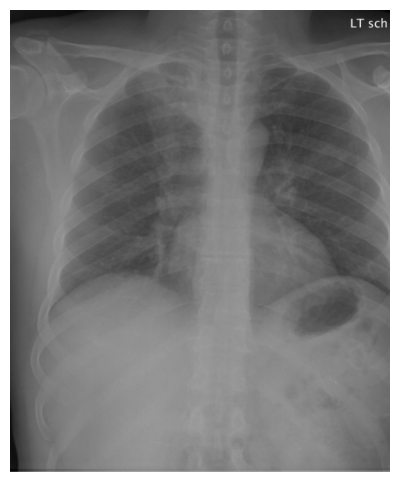

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Generated report (beam):
 Findings: the lungs are clear without focal consolidation effusion or pneumothorax . the cardiomediastinal silhouette is within normal limits . imaged osseous structures are intact . no free air below the right hemidiaphragm is seen .
Impression: no acute intrathoracic process . <|endoftext|>1 . 2 . 3 . 4 . 5 . 6 . 7 . 8 . 9 . 10 . 11 . 12 . 13 . no


In [28]:
report_beam = trainer.robust_generate_radiology_report(
    image_input=["/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/CXR1000_IM-0003-1001.png"],
    max_tokens=200,
    deterministic=True,
    beam_width=3,
    show_image=True # Set to True if you want to see the image
)

print("Generated report (beam):\n", report_beam)

In [29]:
# from torch.utils.data import ConcatDataset, DataLoader
# from PIL import Image
# from nltk.tokenize import word_tokenize
# from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
# from nltk.translate.meteor_score import single_meteor_score
# from rouge_score import rouge_scorer
# from tqdm import tqdm
# import pandas as pd
# def evaluate_dataloader_metrics_v2(dataloader, trainer, tokenizer, device, max_samples=None):
#     results = []
#     sample_count = 0
#     smooth = SmoothingFunction()
#     rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

#     for batch in tqdm(dataloader, desc="Evaluating dataset"):
#         input_ids = batch['input_ids']
#         image_paths_list = batch['image_paths']  # <- list of lists: one per sample

#         for i in range(len(image_paths_list)):
#             if max_samples and sample_count >= max_samples:
#                 break

#             gt_input_ids = input_ids[i]
#             if tokenizer.pad_token_id is not None:
#                 gt_input_ids = gt_input_ids[gt_input_ids != tokenizer.pad_token_id]
#             reference_text = tokenizer.decode(gt_input_ids, skip_special_tokens=True)
#             if not isinstance(reference_text, str) or len(reference_text.strip()) == 0:
#                 continue

#             # --- Load all image views for this report ---
#             pil_imgs = []
#             for image_path in image_paths_list[i]:
#                 pil_img = Image.open(image_path).convert('RGB')
#                 pil_imgs.append(pil_img)
#             # --- Generate report from all images for this study ---
#             gen_report = trainer.robust_generate_radiology_report(
#                 pil_imgs,
#                 max_tokens=350,
#                 deterministic=True,
#                 beam_width=1,
#             )
            
            
#             # --- TOKENIZATION FOR METRICS ---
#             ref_tokens = word_tokenize(reference_text)
#             hyp_tokens = word_tokenize(gen_report)
#             # BLEU scores for n = 1, 2, 3, 4
#             bleu1 = sentence_bleu([ref_tokens], hyp_tokens, weights=(1, 0, 0, 0), smoothing_function=smooth.method1)
#             bleu2 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth.method1)
#             bleu3 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth.method1)
#             bleu4 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth.method1)

#             # METEOR (pass as strings, NOT as lists)
#             meteor = single_meteor_score(ref_tokens, hyp_tokens)


#             # ROUGE-L
#             rouge_l_score = rouge.score(reference_text, gen_report)['rougeL'].fmeasure

#             results.append({
#                 'BLEU-1': bleu1,
#                 'BLEU-2': bleu2,
#                 'BLEU-3': bleu3,
#                 'BLEU-4': bleu4,
#                 'METEOR': meteor,
#                 'ROUGE-L': rouge_l_score
#             })
#             sample_count += 1
#             if max_samples and sample_count >= max_samples:
#                 break
#         if max_samples and sample_count >= max_samples:
#             break

#     results_df = pd.DataFrame(results)
#     avg_scores = results_df.mean().to_dict()
#     return results_df, avg_scores

# # --- Example usage ---
# results_df, avg_scores = evaluate_dataloader_metrics_v2(test_loader, trainer, tokenizer, train_config.device)
# print(results_df)
# print('Average Scores:', avg_scores)


In [30]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import random

def evaluate_on_test_samples(trainer, test_loader, tokenizer, num_samples=5):
    """
    Selects random samples from a batch of the test_loader, displays the images,
    and compares the ground truth report to the model-generated report.
    """
    # Ensure the model is in evaluation mode
    trainer.vl_model.eval()

    # De-normalization constants for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    print(f"Fetching a batch from the test loader to evaluate {num_samples} random samples...")
    try:
        # Get a single batch from the test_loader
        sample_batch = next(iter(test_loader))
    except StopIteration:
        print("Test loader is empty. Cannot evaluate.")
        return

    images_batch = sample_batch['images']      # Shape: (batch, max_views, 3, H, W)
    input_ids_batch = sample_batch['input_ids']    # Shape: (batch, seq_len)
    view_mask_batch = sample_batch['view_mask']    # Shape: (batch, max_views)

    # Ensure we don't try to sample more than we have in the batch
    actual_batch_size = images_batch.size(0)
    if actual_batch_size == 0:
        print("Batch is empty. Cannot evaluate.")
        return
        
    num_samples_to_show = min(num_samples, actual_batch_size)
    
    # Select random indices from the batch
    selected_indices = random.sample(range(actual_batch_size), num_samples_to_show)

    for i, idx in enumerate(selected_indices):
        print(f"\n{'='*30} EVALUATING SAMPLE {i+1}/{num_samples_to_show} {'='*30}")
        
        # This list will hold the un-normalized PIL images for the current study
        pil_images_for_generation = []
        
        # Get the valid views for the selected study using the view_mask
        view_mask = view_mask_batch[idx]
        num_views = int(view_mask.sum())
        
        plt.figure(figsize=(6 * num_views, 6))

        for view_idx in range(view_mask.size(0)):
            if view_mask[view_idx].item() == 1:  # Process only valid views
                # Get the normalized image tensor from the batch
                image_tensor = images_batch[idx, view_idx].cpu()
                
                # De-normalize the tensor to create a displayable image
                display_image_tensor = (image_tensor * std) + mean
                display_image_tensor = torch.clamp(display_image_tensor, 0, 1)
                pil_img = transforms.ToPILImage()(display_image_tensor)
                
                pil_images_for_generation.append(pil_img)
                
                # Plot the de-normalized image
                plt.subplot(1, num_views, len(pil_images_for_generation))
                plt.imshow(pil_img)
                plt.title(f"View {len(pil_images_for_generation)}")
                plt.axis('off')
        
        plt.show()

        # Decode the ground truth report
        ground_truth_ids = input_ids_batch[idx]
        ground_truth_report = tokenizer.decode(ground_truth_ids, skip_special_tokens=True)

        # Generate the report from the list of PIL images
        # The robust_generate_radiology_report function will handle the necessary transformations internally
        generated_report = trainer.robust_generate_radiology_report(
            image_input=pil_images_for_generation,
            max_tokens=350,
            deterministic=True, # Use deterministic for consistent evaluation
            beam_width=3,       # Beam search can produce better results
        )

        # Display the comparison
        print(f"\n--- Ground Truth Report ---")
        print(ground_truth_report.strip())
        print(f"\n--- Generated Report ---")
        print(generated_report.strip())
        print("-" * 80)



Fetching a batch from the test loader to evaluate 5 random samples...

============================== EVALUATING SAMPLE 1/4 ==============================


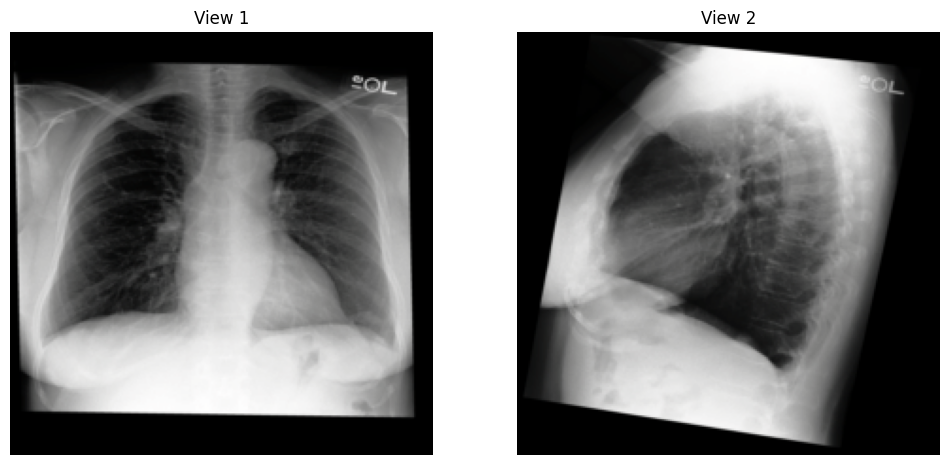


--- Ground Truth Report ---
there is mild left base atelectasis seen on the frontal view without clear correlate on the lateral view . no definite focal consolidation is seen . there is no pleural effusion or pneumothorax . the aorta is slightly tortuous . the cardiac silhouette is not enlarged . there is no overt pulmonary edema .  mild left base atelectasis . otherwise no acute cardiopulmonary process .

--- Generated Report ---
Findings: the lungs are clear without focal consolidation effusion or pneumothorax . the cardiomediastinal silhouette is within normal limits . imaged osseous structures are intact . no free air below the right hemidiaphragm is seen .
Impression: no acute intrathoracic process . <|endoftext|>demonstration of the right ij central venous catheter . the tip of the catheter projects over the right ventricle . the tip of the catheter
--------------------------------------------------------------------------------

============================== EVALUATING SAMPLE 

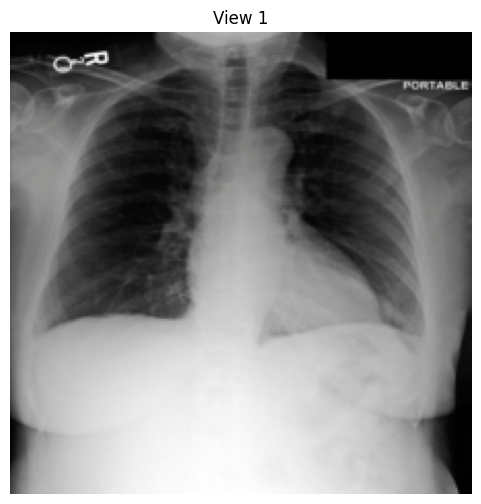


--- Ground Truth Report ---
as compared to the previous radiograph there is evidence of an unchanged picc line placed over the right upper extremity . the tip appears to project over the azygous vein at the level of the upper svc . no complications notably no pneumothorax . borderline size of the cardiac silhouette . moderate tortuosity of the thoracic aorta .

--- Generated Report ---
Findings: the lungs are clear without focal consolidation effusion or pneumothorax . the cardiomediastinal silhouette is within normal limits . imaged osseous structures are intact . no free air below the right hemidiaphragm is seen .
Impression: no acute intrathoracic process . <|endoftext|>demonstration of the right ij central venous catheter . the tip of the catheter projects over the right ventricle . the tip of the catheter
--------------------------------------------------------------------------------

============================== EVALUATING SAMPLE 3/4 ==============================


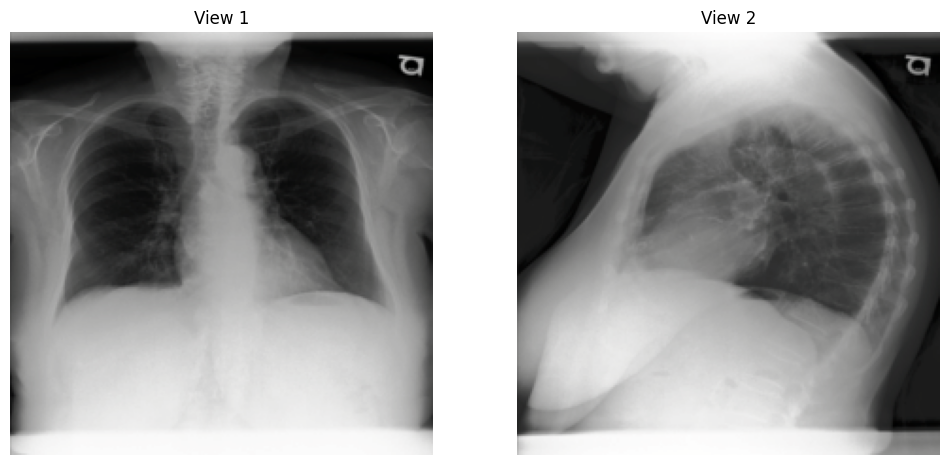


--- Ground Truth Report ---
as compared to the prior examination dated there has been no significant interval change . there is no evidence of focal consolidation pleural effusion pneumothorax or frank pulmonary edema . the cardiomediastinal silhouette is within normal limits . there is persistent thoracic kyphosis with mild wedging of a mid thoracic vertebral body .  no evidence of acute cardiopulmonary process .

--- Generated Report ---
Findings: the lungs are clear without focal consolidation effusion or pneumothorax . the cardiomediastinal silhouette is within normal limits . imaged osseous structures are intact . no free air below the right hemidiaphragm is seen .
Impression: no acute intrathoracic process . <|endoftext|>demonstration of the right ij central venous catheter . the tip of the catheter projects over the right ventricle . the tip of the catheter
--------------------------------------------------------------------------------

============================== EVALUATIN

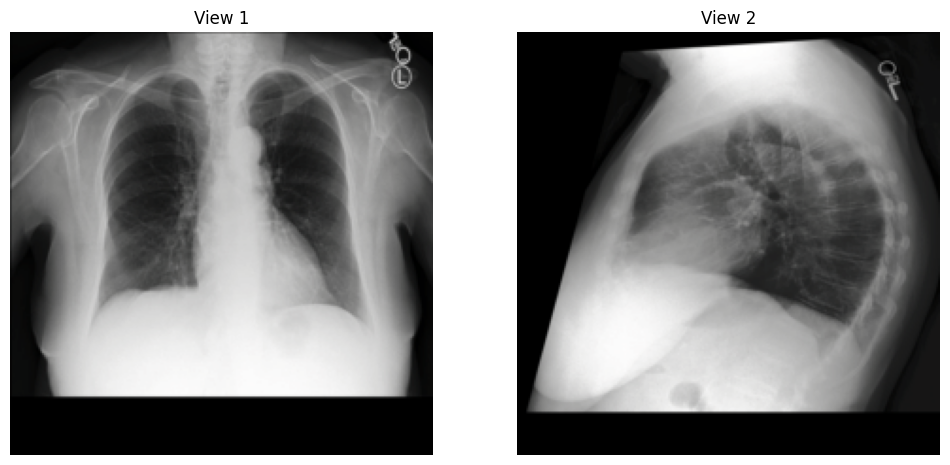


--- Ground Truth Report ---
pa and lateral views of the chest provided . lung volumes are somewhat low . there is no focal consolidation effusion or pneumothorax . the cardiomediastinal silhouette is normal . imaged osseous structures are intact . no free air below the right hemidiaphragm is seen .  no acute intrathoracic process .

--- Generated Report ---
Findings: the lungs are clear without focal consolidation effusion or pneumothorax . the cardiomediastinal silhouette is within normal limits . imaged osseous structures are intact . no free air below the right hemidiaphragm is seen .
Impression: no acute intrathoracic process . <|endoftext|>demonstration of the right ij central venous catheter . the tip of the catheter projects over the mid svc . the tip of the catheter projects over the mid svc. the tip of the catheter projects over the mid svc
--------------------------------------------------------------------------------


In [31]:
evaluate_on_test_samples(trainer, test_loader, tokenizer, num_samples=5)

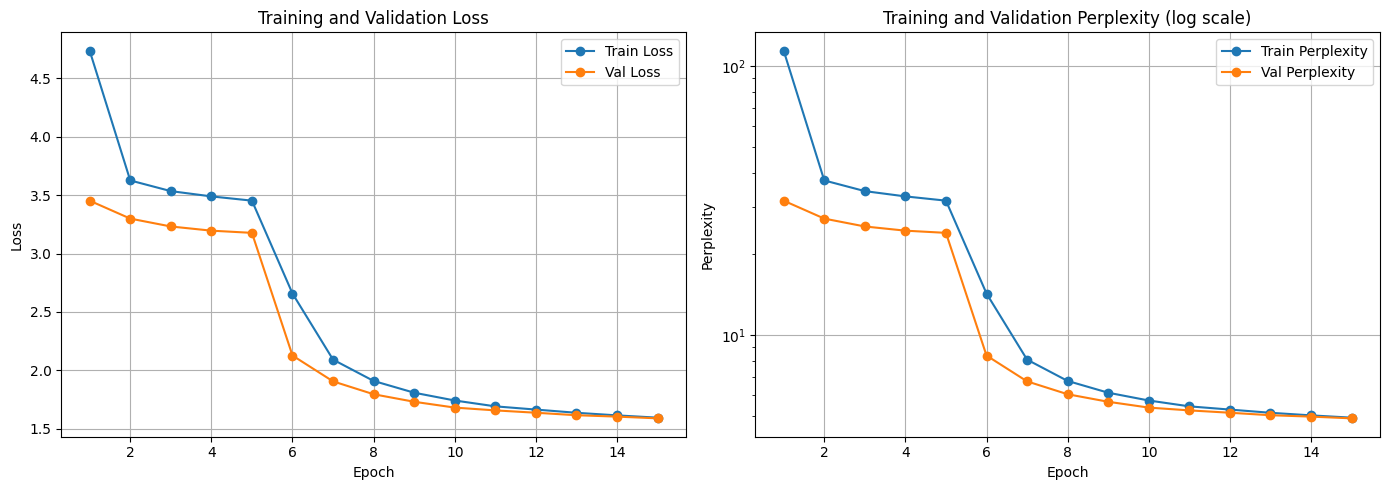

In [32]:
trainer.plot_loss_and_perplexity()